# Bankruptcy Prevention - End-to-End Classification Project
**Objective:** Predict bankruptcy probability from 6 risk features using machine learning

# EDA - EXPLORATORY DATA ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

features = [
    'industrial_risk',
    'management_risk',
    'financial_flexibility',
    'credibility',
    'competitiveness',
    'operating_risk'
]

data_path = 'Bankruptcy (2).xlsx'

print("📊 Loading data from Excel file...")
df = pd.read_excel(data_path)

print("\n" + "="*80)
print("🔍 COMPREHENSIVE DATA EXPLORATION")
print("="*80)

print("\n1️⃣ First 10 rows of the dataset:")
print(df.head(10))

print("\n2️⃣ Column names:")
print(df.columns.tolist())

print("\n3️⃣ Dataset shape:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n4️⃣ Dataset info:")
df.info()

print("\n5️⃣ Data types:")
print(df.dtypes)

print("\n6️⃣ Missing values per column:")
missing_values = df.isna().sum()
print(missing_values)
if missing_values.sum() > 0:
    print(f"Total missing values: {missing_values.sum()}")
else:
    print("✅ No missing values found!")

print("\n7️⃣ Duplicate rows:")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print("⚠️  Duplicate rows detected - will be handled during preprocessing")
else:
    print("✅ No duplicate rows found!")

print("\n" + "="*80)
print("🔧 DATA PREPROCESSING")
print("="*80)

print("\n📝 Normalizing column names...")
raw_df = df.copy()
raw_df.columns = [c.strip().lower().replace(' ', '_') for c in raw_df.columns]
print("Original columns:", df.columns.tolist())
print("Normalized columns:", raw_df.columns.tolist())

print("\n🎯 Locating target column...")
if 'class' not in raw_df.columns:
    for cand in ['bankruptcy', 'target', 'label']:
        if cand in raw_df.columns:
            raw_df = raw_df.rename(columns={cand: 'class'})
            print(f"✅ Found target column: '{cand}' -> renamed to 'class'")
            break
    else:
        print("❌ Target column 'class' not found after checking alternatives")
else:
    print("✅ Target column 'class' found")

available_features = [c for c in features if c in raw_df.columns]
missing_features = [c for c in features if c not in raw_df.columns]
print(f"\n🔍 Feature column analysis:")
print(f"Available features: {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")
    raise ValueError(f"Missing expected feature columns: {missing_features}")

features = available_features

if 'class' not in raw_df.columns:
    raise ValueError("Target column 'class' not found after loading.")

print("\n🔄 Converting target to binary...")
if raw_df['class'].dtype == object:
    print("Target column is object type, mapping values...")
    class_map = {
        'no': 0, 'non-bankruptcy': 0, 'non_bankruptcy': 0, 'non bankruptcy': 0,
        'yes': 1, 'bankruptcy': 1
    }
    raw_df['class'] = raw_df['class'].astype(str).str.strip().str.lower().map(class_map)
    print(f"Unique target values after mapping: {raw_df['class'].unique()}")

raw_df['class'] = raw_df['class'].astype(int)

print("\n🔄 Converting ordinal features to numeric...")
ordinal_map = {
    'low': 0.0,
    'medium': 0.5,
    'med': 0.5,
    'high': 1.0
}
for col in available_features:
    if raw_df[col].dtype == object:
        print(f"Converting {col} from object to numeric...")
        raw_df[col] = (
            raw_df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .map(ordinal_map)
        )
    raw_df[col] = raw_df[col].astype(float)

print("\n🧹 Cleaning data...")
work_df = raw_df[available_features + ['class']].dropna().copy()
print(f"Rows before cleaning: {len(raw_df)}")
print(f"Rows after cleaning: {len(work_df)}")
print(f"Rows removed: {len(raw_df) - len(work_df)}")

print("\n🔄 Deduplicating rows...")
work_df['frequency'] = 1
agg_cols = available_features + ['class']
dedup_df = (
    work_df
    .groupby(agg_cols, as_index=False)['frequency']
    .sum()
    .sort_values('frequency', ascending=False)
    .reset_index(drop=True)
)

print('✅ Data loaded and deduplicated.')
print(f"Shape before dedup: {len(work_df)} | after dedup: {len(dedup_df)}")
print('Feature columns:', available_features)
print('Class distribution (dedup, weighted by frequency):')
print(dedup_df.groupby('class')['frequency'].sum())

print("\n" + "="*80)
print("✅ DATA LOADING AND PREPROCESSING COMPLETE")
print("="*80)


📊 Loading data from Excel file...

🔍 COMPREHENSIVE DATA EXPLORATION

1️⃣ First 10 rows of the dataset:
   industrial_risk  management_risk  financial_flexibility  credibility  \
0              0.5              1.0                    0.0          0.0   
1              0.0              1.0                    0.0          0.0   
2              1.0              0.0                    0.0          0.0   
3              0.5              0.0                    0.0          0.5   
4              1.0              1.0                    0.0          0.0   
5              1.0              1.0                    0.0          0.5   
6              1.0              1.0                    0.0          0.0   
7              1.0              1.0                    0.0          0.0   
8              1.0              1.0                    0.0          0.5   
9              1.0              1.0                    0.0          0.5   

   competitiveness  operating_risk       class  
0              0.0    

In [2]:
print("\n--- Post-Cleaning Validation ---")
print(f"Deduplicated shape: {dedup_df.shape}")
print(f"Duplicate rows remaining: {dedup_df.duplicated().sum()}")
print(f"Class balance:\n{dedup_df['class'].value_counts()}")
for col in features:
    valid = dedup_df[col].isin([0, 0.5, 1]).all()
    print(f"Feature '{col}' domain valid: {valid}")



--- Post-Cleaning Validation ---
Deduplicated shape: (103, 8)
Duplicate rows remaining: 0
Class balance:
class
0    78
1    25
Name: count, dtype: int64
Feature 'industrial_risk' domain valid: True
Feature 'management_risk' domain valid: True
Feature 'financial_flexibility' domain valid: True
Feature 'credibility' domain valid: True
Feature 'competitiveness' domain valid: True
Feature 'operating_risk' domain valid: True


Chi-Square Test Results (Feature vs Target):
industrial_risk                | Chi2:    15.91 | p-value: 0.0004 | Significant
management_risk                | Chi2:    35.14 | p-value: 0.0000 | Significant
financial_flexibility          | Chi2:   171.01 | p-value: 0.0000 | Significant
credibility                    | Chi2:   157.64 | p-value: 0.0000 | Significant
competitiveness                | Chi2:   234.83 | p-value: 0.0000 | Significant
operating_risk                 | Chi2:    19.64 | p-value: 0.0001 | Significant


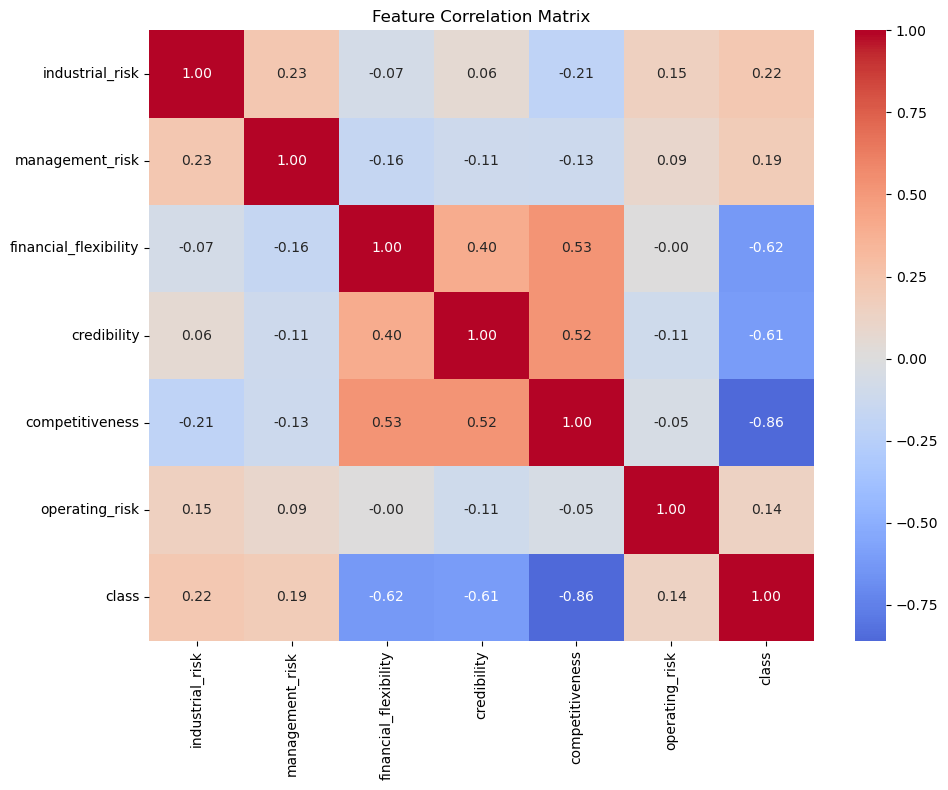

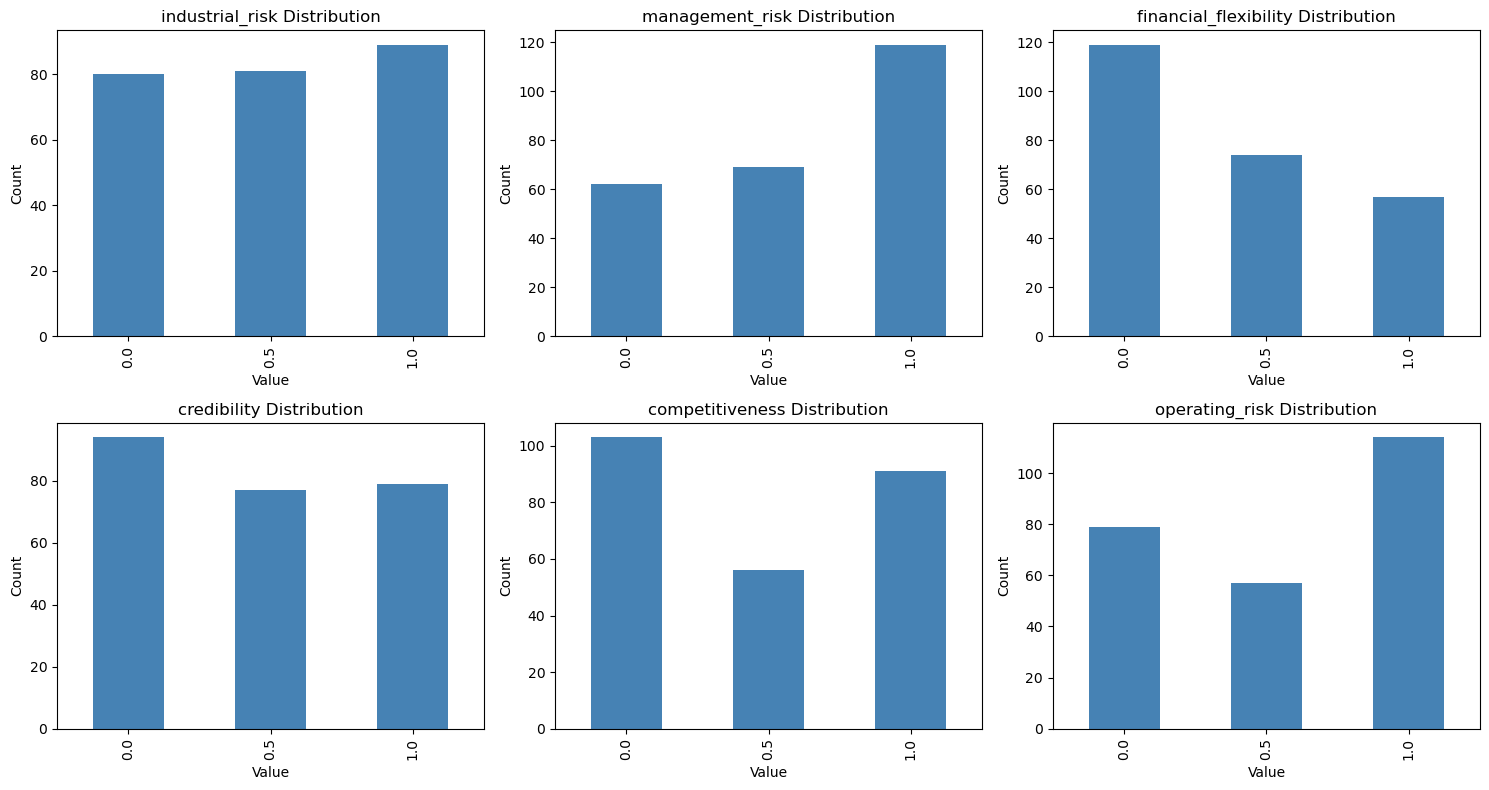

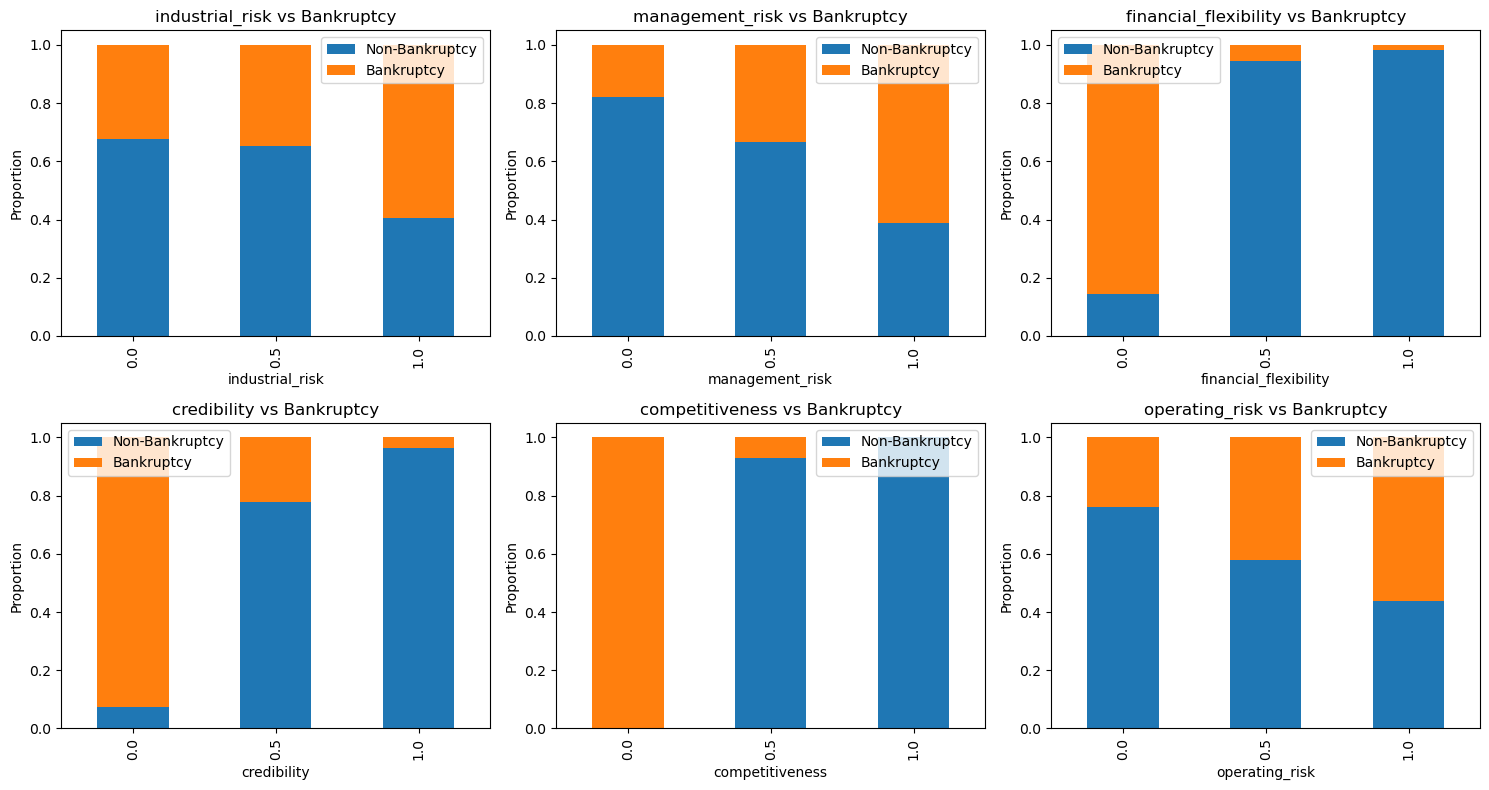

In [3]:
print("Chi-Square Test Results (Feature vs Target):")
print("="*70)
chi_results = []
for feat in features:
    cat = (dedup_df[feat] * 2).astype(int)
    contingency = pd.crosstab(cat, dedup_df['class'], values=dedup_df['frequency'], aggfunc='sum').fillna(0)
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi_results.append((feat, chi2, p))
    print(f"{feat:30s} | Chi2: {chi2:8.2f} | p-value: {p:.4f} | {'Significant' if p < 0.05 else 'Not Significant'}")

plt.figure(figsize=(10, 8))
sns.heatmap(dedup_df[features + ['class']].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, col in enumerate(features):
    dedup_df.groupby(col)['frequency'].sum().sort_index().plot(kind='bar', ax=axes[i], color='steelblue')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, col in enumerate(features):
    crosstab = pd.crosstab(dedup_df[col], dedup_df['class'], values=dedup_df['frequency'], aggfunc='sum', normalize='index').fillna(0)
    crosstab.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].set_title(f'{col} vs Bankruptcy')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(['Non-Bankruptcy', 'Bankruptcy'])
plt.tight_layout()
plt.show()


Training set: (82, 6)
Test set: (21, 6)
Class distribution (train):
class
0    62
1    20
Name: count, dtype: int64
After CTGAN augmentation: (500, 6)
Class distribution (augmented):
class
0    295
1    205
Name: count, dtype: int64


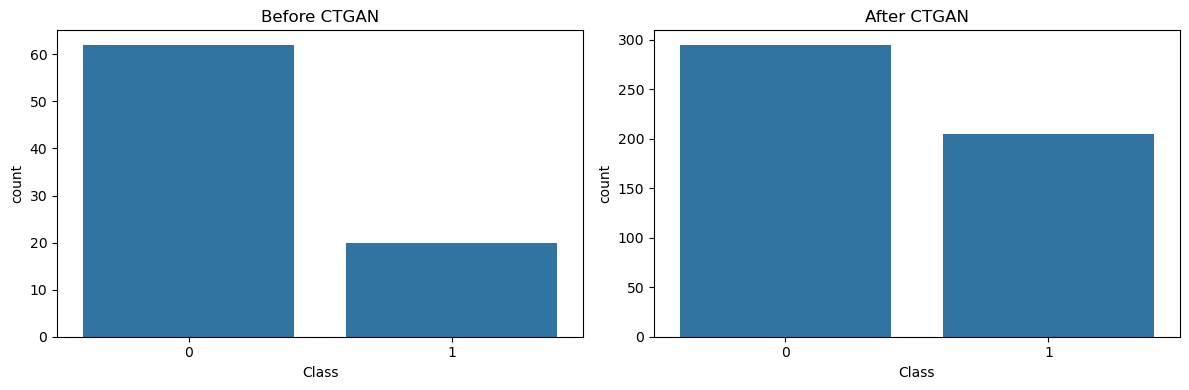

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ctgan import CTGAN

X = dedup_df[features]
y = dedup_df['class']
sample_weight = dedup_df['frequency']
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution (train):\n{y_train.value_counts()}")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
train_data = X_train_scaled_df.copy()
train_data['class'] = y_train.values

ctgan = CTGAN(epochs=300)
ctgan.fit(train_data, discrete_columns=['class'])

n_to_generate = max(0, 500 - len(X_train))
syn_data = ctgan.sample(n_to_generate)

X_syn = syn_data[features]
y_syn = syn_data['class']
X_syn_inv = scaler.inverse_transform(X_syn)
X_syn_inv_df = pd.DataFrame(X_syn_inv, columns=features)

X_train_aug = pd.concat([X_train, X_syn_inv_df], ignore_index=True)
y_train_aug = pd.concat([y_train, pd.Series(y_syn)], ignore_index=True)
sw_train_aug = pd.concat([pd.Series(sw_train), pd.Series([1]*n_to_generate)], ignore_index=True)

print(f"After CTGAN augmentation: {X_train_aug.shape}")
print(f"Class distribution (augmented):\n{y_train_aug.value_counts()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Before CTGAN')
axes[0].set_xlabel('Class')
sns.countplot(x=y_train_aug, ax=axes[1])
axes[1].set_title('After CTGAN')
axes[1].set_xlabel('Class')
plt.tight_layout()
plt.show()


In [5]:
X_real = dedup_df[features]
y_real = dedup_df['class']
sw_real = dedup_df['frequency']

print(f"Loaded {len(X_real)} unique real samples for cross-validation.")
print(f"Real Class Distribution:\n{y_real.value_counts()}")


Loaded 103 unique real samples for cross-validation.
Real Class Distribution:
class
0    78
1    25
Name: count, dtype: int64


# MODEL TRAINING

In [7]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from ctgan import CTGAN
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# --- keep your 'models' dict here (unchanged) ---
models = {
    'Logistic Regression': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
        'params': {'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2']}
    },
    'Random Forest': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))]),
        'params': {'clf__n_estimators': [100, 200], 'clf__max_depth': [5, 10, None], 'clf__min_samples_split': [2, 5], 'clf__min_samples_leaf': [1, 2]}
    },
    'XGBoost': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))]),
        'params': {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 5, 7], 'clf__learning_rate': [0.01, 0.1]}
    },
    'SVM': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=42))]),
        'params': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}
    },
    'KNN': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
        'params': {'clf__n_neighbors': [3, 5, 7], 'clf__weights': ['uniform', 'distance']}
    }
}

N_SPLITS = 5
outer_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

outer_results = {name: {'f1': [], 'roc_auc': [], 'precision': [], 'recall': []} for name in models.keys()}
best_params_map = {name: [] for name in models.keys()}

print(f"Starting Robust {N_SPLITS}-Fold Cross-Validation on {len(X_real)} real samples...")

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_real, y_real)):
    print(f"\n--- FOLD {fold_idx+1}/{N_SPLITS} ---")

    # reset indices to avoid alignment/index problems later
    X_train_fold = X_real.iloc[train_idx].reset_index(drop=True)
    X_test_fold = X_real.iloc[test_idx].reset_index(drop=True)
    y_train_fold = y_real.iloc[train_idx].reset_index(drop=True)
    y_test_fold = y_real.iloc[test_idx].reset_index(drop=True)
    sw_train_fold = sw_real.iloc[train_idx].reset_index(drop=True)

    print("   Augmenting data for this fold...")
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_fold), columns=X_train_fold.columns)

    train_data_for_gan = X_train_scaled.copy()
    train_data_for_gan['class'] = y_train_fold.values

    # generate synthetic rows if training set is smaller than target (e.g. 500)
    n_to_generate = max(0, 500 - len(X_train_fold))
    if n_to_generate > 0:
        ctgan = CTGAN(epochs=300, verbose=False)
        ctgan.fit(train_data_for_gan, discrete_columns=['class'])
        syn_data = ctgan.sample(n_to_generate)

        # inverse-transform synthetic features to original scale
        X_syn_inv = pd.DataFrame(scaler.inverse_transform(syn_data[X_train_fold.columns]),
                                 columns=X_train_fold.columns)

        X_train_aug = pd.concat([X_train_fold, X_syn_inv], ignore_index=True)
        y_train_aug = pd.concat([y_train_fold, syn_data['class'].reset_index(drop=True)], ignore_index=True)
        sw_syn = pd.Series([1] * n_to_generate)  # assign weight=1 for synthetic rows
        sw_train_aug = pd.concat([sw_train_fold.reset_index(drop=True), sw_syn], ignore_index=True)
    else:
        # no synthetic data needed
        X_train_aug = X_train_fold
        y_train_aug = y_train_fold
        sw_train_aug = sw_train_fold

    for name, config in models.items():
        print(f"   Tuning {name}...")
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # pass sample weights only to estimators that accept them
        if name in ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM']:
            fit_params = {'clf__sample_weight': sw_train_aug.values}
        else:
            fit_params = {}

        search = GridSearchCV(config['pipeline'], config['params'], cv=inner_cv, scoring='roc_auc', n_jobs=-1)
        search.fit(X_train_aug, y_train_aug, **fit_params)

        best_fold_model = search.best_estimator_
        best_params_map[name].append(search.best_params_)

        y_pred = best_fold_model.predict(X_test_fold)

        # get probability predictions robustly
        if hasattr(best_fold_model, "predict_proba"):
            y_proba = best_fold_model.predict_proba(X_test_fold)[:, 1]
        else:
            # fallback: use decision_function -> scale to [0,1]
            if hasattr(best_fold_model, "decision_function"):
                scores = best_fold_model.decision_function(X_test_fold)
                y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
            else:
                # last fallback: use predicted labels as 0/1 probabilities
                y_proba = y_pred

        outer_results[name]['f1'].append(f1_score(y_test_fold, y_pred))
        outer_results[name]['roc_auc'].append(roc_auc_score(y_test_fold, y_proba))
        outer_results[name]['precision'].append(precision_score(y_test_fold, y_pred, zero_division=0))
        outer_results[name]['recall'].append(recall_score(y_test_fold, y_pred, zero_division=0))

# --- aggregate and print results as you had before ---
final_results_list = []
for name in models.keys():
    final_results_list.append({
        'Model': name,
        'Mean F1': np.mean(outer_results[name]['f1']),
        'Std F1': np.std(outer_results[name]['f1']),
        'Mean ROC-AUC': np.mean(outer_results[name]['roc_auc']),
        'Std ROC-AUC': np.std(outer_results[name]['roc_auc']),
        'Mean Precision': np.mean(outer_results[name]['precision']),
        'Mean Recall': np.mean(outer_results[name]['recall']),
    })

final_results_df = pd.DataFrame(final_results_list).sort_values('Mean ROC-AUC', ascending=False)
print("--- RELIABLE MODEL PERFORMANCE (from 5-Fold CV) ---")
print(final_results_df.to_string(index=False, float_format='{:.4f}'.format))

best_model_name = final_results_df.iloc[0]['Model']
best_param_list = [str(p) for p in best_params_map[best_model_name]]
most_common_params_str = Counter(best_param_list).most_common(1)[0][0]
final_best_params = eval(most_common_params_str)

print(f"\n✅ Best Model Type (based on Mean ROC-AUC): {best_model_name}")
print(f"   Most Frequent Best Params: {final_best_params}")


Starting Robust 5-Fold Cross-Validation on 103 real samples...

--- FOLD 1/5 ---
   Augmenting data for this fold...
   Tuning Logistic Regression...
   Tuning Random Forest...
   Tuning XGBoost...
   Tuning SVM...
   Tuning KNN...

--- FOLD 2/5 ---
   Augmenting data for this fold...
   Tuning Logistic Regression...
   Tuning Random Forest...
   Tuning XGBoost...
   Tuning SVM...
   Tuning KNN...

--- FOLD 3/5 ---
   Augmenting data for this fold...
   Tuning Logistic Regression...
   Tuning Random Forest...
   Tuning XGBoost...
   Tuning SVM...
   Tuning KNN...

--- FOLD 4/5 ---
   Augmenting data for this fold...
   Tuning Logistic Regression...
   Tuning Random Forest...
   Tuning XGBoost...
   Tuning SVM...
   Tuning KNN...

--- FOLD 5/5 ---
   Augmenting data for this fold...
   Tuning Logistic Regression...
   Tuning Random Forest...
   Tuning XGBoost...
   Tuning SVM...
   Tuning KNN...
--- RELIABLE MODEL PERFORMANCE (from 5-Fold CV) ---
              Model  Mean F1  Std F1  Me

In [8]:
import joblib
import os

print(f"--- Training Final Production Model: {best_model_name} ---")

print("Augmenting all 103 real samples for final training...")
scaler = MinMaxScaler()
X_real_scaled_df = pd.DataFrame(scaler.fit_transform(X_real), columns=features, index=X_real.index)
full_train_data_for_gan = X_real_scaled_df.copy()
full_train_data_for_gan['class'] = y_real

ctgan = CTGAN(epochs=300, verbose=False)
ctgan.fit(full_train_data_for_gan, discrete_columns=['class'])

n_to_generate = max(0, 500 - len(X_real))
syn_data = ctgan.sample(n_to_generate)
X_syn_inv_df = pd.DataFrame(scaler.inverse_transform(syn_data[features]), columns=features)

X_final_aug = pd.concat([X_real, X_syn_inv_df], ignore_index=True)
y_final_aug = pd.concat([y_real, syn_data['class']], ignore_index=True)
sw_final_aug = pd.concat([sw_real, pd.Series([1]*n_to_generate, index=syn_data.index)], ignore_index=True)

print(f"Final training set size: {len(X_final_aug)}")

final_pipeline = models[best_model_name]['pipeline']
final_pipeline.set_params(**final_best_params)

print("Fitting final model...")
if best_model_name in ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM']:
    fit_params = {'clf__sample_weight': sw_final_aug}
else:
    fit_params = {}

final_pipeline.fit(X_final_aug, y_final_aug, **fit_params)

print("✅ Final model training complete.")


--- Training Final Production Model: Random Forest ---
Augmenting all 103 real samples for final training...
Final training set size: 500
Fitting final model...
✅ Final model training complete.


--- Final Model Performance (Averaged from 5-Fold CV) ---
              Model  Mean F1  Std F1  Mean ROC-AUC  Std ROC-AUC  Mean Precision  Mean Recall
      Random Forest   0.9596  0.0499        1.0000       0.0000          0.9667       0.9600
            XGBoost   0.9374  0.0517        0.9973       0.0053          0.9667       0.9200
Logistic Regression   0.9778  0.0444        0.9947       0.0107          1.0000       0.9600
                SVM   0.9044  0.0830        0.9843       0.0128          0.9029       0.9200
                KNN   0.9081  0.0537        0.9820       0.0223          0.8762       0.9600


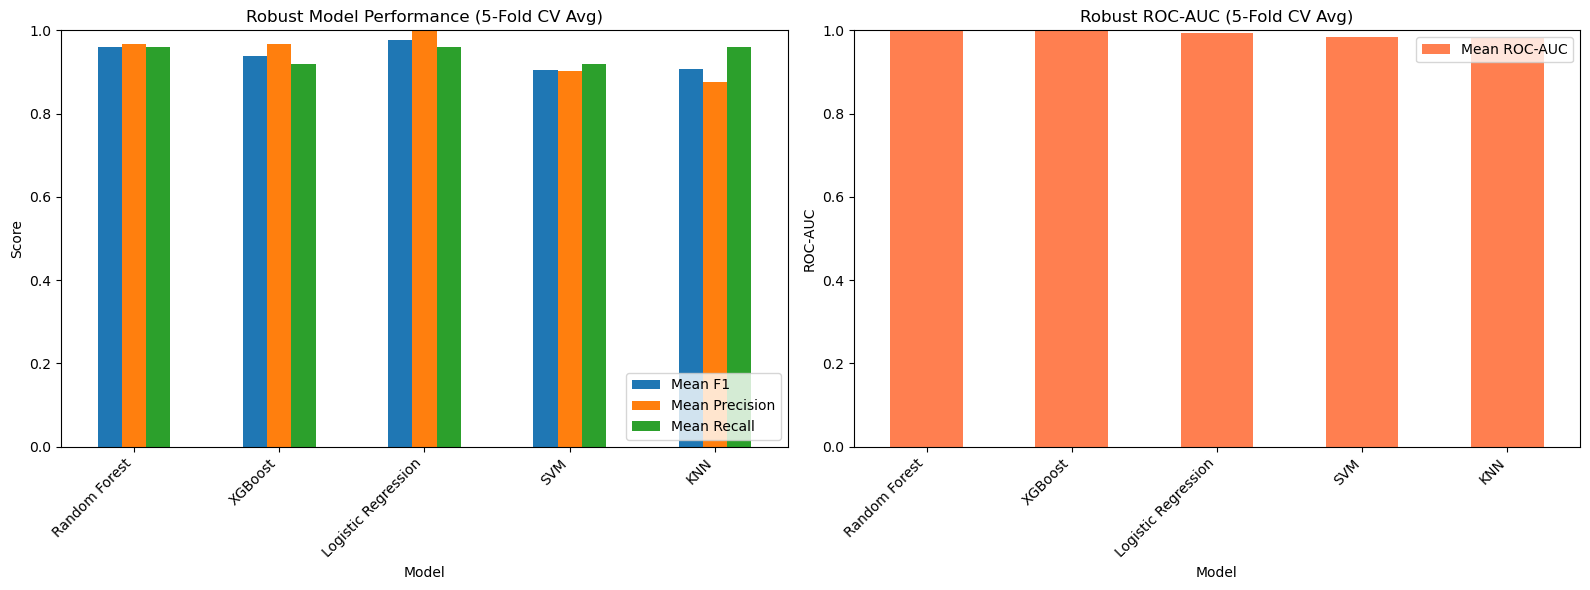

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay

print("--- Final Model Performance (Averaged from 5-Fold CV) ---")
print(final_results_df.to_string(index=False, float_format='{:.4f}'.format))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

final_results_df.plot(x='Model', y=['Mean F1', 'Mean Precision', 'Mean Recall'], kind='bar', ax=axes[0])
axes[0].set_title('Robust Model Performance (5-Fold CV Avg)')
axes[0].set_ylabel('Score')
axes[0].set_xticklabels(final_results_df['Model'], rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1])

final_results_df.plot(x='Model', y=['Mean ROC-AUC'], kind='bar', ax=axes[1], color=['coral'])
axes[1].set_title('Robust ROC-AUC (5-Fold CV Avg)')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_xticklabels(final_results_df['Model'], rotation=45, ha='right')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


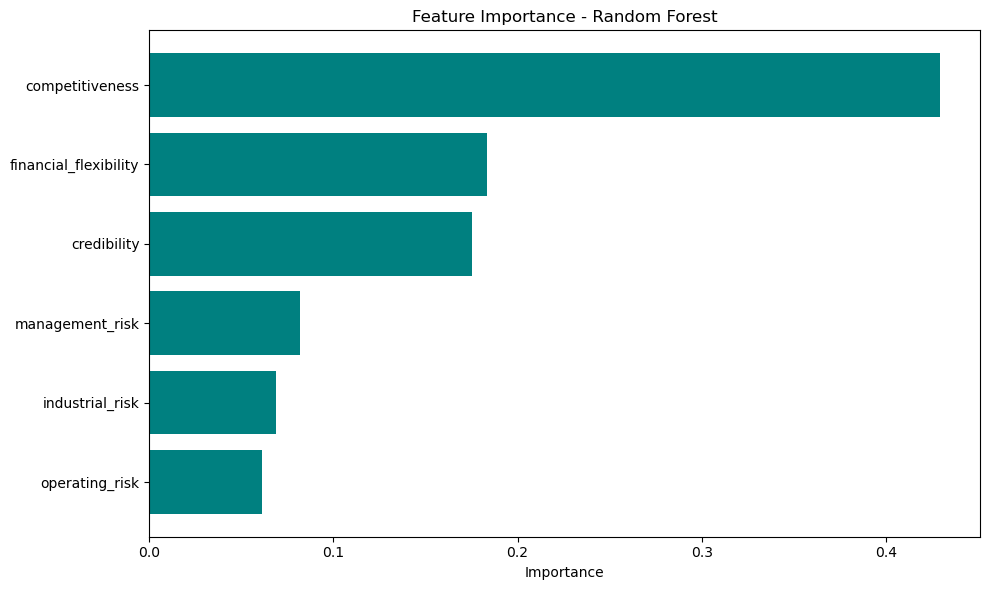


Feature Importance Ranking:
              Feature  Importance
      competitiveness    0.429526
financial_flexibility    0.183463
          credibility    0.175153
      management_risk    0.081844
      industrial_risk    0.068746
       operating_risk    0.061268


In [10]:
if hasattr(final_pipeline.named_steps['clf'], 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': final_pipeline.named_steps['clf'].feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nFeature Importance Ranking:")
    print(importance_df.to_string(index=False))
else:
    print(f"Feature importance not available for {best_model_name}")


# MODEL EVALUATION

# Model Saving for Deployment 

In [11]:
import joblib
import os
from datetime import datetime

os.makedirs('../model', exist_ok=True)
artifact_path = '../model/bankruptcy_model_v3.pkl'
joblib.dump(final_pipeline, artifact_path)
joblib.dump(features, '../model/feature_names.pkl')

print(f"✅ Final model saved to {artifact_path}")
print("✅ Features saved to ../model/feature_names.pkl")

perf = final_results_df[final_results_df['Model'] == best_model_name].iloc[0]

model_metadata = {
    'model_name': best_model_name,
    'best_params': final_best_params,
    'performance': {
        'mean_precision': perf['Mean Precision'],
        'mean_recall': perf['Mean Recall'],
        'mean_f1_score': perf['Mean F1'],
        'mean_roc_auc': perf['Mean ROC-AUC'],
        'std_roc_auc': perf['Std ROC-AUC']
    },
    'features': features,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_version': 'v3.1_Robust_CV',
    'notes': '5-model suite (LR/RF/XGB/SVM/KNN). CTGAN augmentation. Performance from 5-Fold CV on 103 real samples.'
}

joblib.dump(model_metadata, '../model/model_metadata_v3.pkl')
print(f"✅ Model metadata saved to ../model/model_metadata_v3.pkl")
print("\n--- RELIABLE PERFORMANCE METRICS (Saved to file) ---")
print(model_metadata['performance'])


✅ Final model saved to ../model/bankruptcy_model_v3.pkl
✅ Features saved to ../model/feature_names.pkl
✅ Model metadata saved to ../model/model_metadata_v3.pkl

--- RELIABLE PERFORMANCE METRICS (Saved to file) ---
{'mean_precision': 0.9666666666666666, 'mean_recall': 0.96, 'mean_f1_score': 0.9595959595959596, 'mean_roc_auc': 1.0, 'std_roc_auc': 0.0}
